In [3]:
# # Install dependencies (run this cell in Google Colab)
# !pip install diffusers transformers accelerate --quiet
# !pip install pillow torchvision matplotlib tqdm --quiet

import os
import random
import logging
import torch
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
from diffusers import StableDiffusionPipeline
from torchvision import transforms
from tqdm.auto import tqdm

In [4]:
# Configure logging for detailed debug output
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s - %(levelname)s - %(message)s')

def set_seed(seed: int):
    """
    Set the random seed for reproducibility across Python, NumPy, and PyTorch.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    logging.info(f"Random seed set to {seed}.")

def add_watermark(image: Image.Image,
                  watermark_text: str,
                  position: tuple = (10, 10),
                  opacity: int = 128,
                  font_size: int = 20) -> Image.Image:
    """
    Adds a semi-transparent watermark text to the provided image.

    Args:
        image (PIL.Image): The image to watermark.
        watermark_text (str): The text to use as a watermark.
        position (tuple): (x, y) position of the watermark.
        opacity (int): Opacity for the watermark (0-255).
        font_size (int): Font size of the watermark text.

    Returns:
        PIL.Image: The watermarked image.
    """
    # Create an overlay image for the watermark
    watermark = Image.new("RGBA", image.size)
    drawing = ImageDraw.Draw(watermark)

    # Attempt to load a truetype font, fall back to default if not found
    try:
        font = ImageFont.truetype("arial.ttf", font_size)
    except IOError:
        font = ImageFont.load_default()

    # Draw the watermark text onto the overlay image
    drawing.text(position, watermark_text, fill=(255, 255, 255, opacity), font=font)

    # Combine the original image with the watermark overlay
    watermarked = Image.alpha_composite(image.convert("RGBA"), watermark)
    return watermarked.convert("RGB")


In [5]:

def generate_images(prompt: str,
                    num_images: int = 3,
                    save_dir: str = "./generated_images",
                    height: int = 512,
                    width: int = 512,
                    guidance_scale: float = 7.5,
                    num_inference_steps: int = 50,
                    seed: int = None,
                    watermark_text: str = None,
                    output_format: str = "png"):
    """
    Generate synthetic images using Stable Diffusion with enhanced options.

    Args:
        prompt (str): The text prompt guiding image generation.
        num_images (int): Number of images to generate.
        save_dir (str): Directory to save the generated images.
        height (int): Height of the generated images.
        width (int): Width of the generated images.
        guidance_scale (float): Guidance scale (higher values encourage adherence to prompt).
        num_inference_steps (int): Number of denoising steps.
        seed (int): Seed for reproducibility.
        watermark_text (str): Optional watermark text to embed in each image.
        output_format (str): Format to save images ("png" or "jpeg").
    """
    os.makedirs(save_dir, exist_ok=True)

    if seed is not None:
        set_seed(seed)

    model_id = "runwayml/stable-diffusion-v1-5"
    logging.info("Loading Stable Diffusion pipeline...")

    # Use fp16 if GPU is available, otherwise fall back to float32
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model_dtype = torch.float16 if device == "cuda" else torch.float32
    pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=model_dtype)
    pipe = pipe.to(device)
    logging.info(f"Using device: {device}")

    for i in tqdm(range(num_images), desc="Generating images"):
        try:
            # Generate image using the prompt and additional parameters
            output = pipe(prompt,
                          height=height,
                          width=width,
                          guidance_scale=guidance_scale,
                          num_inference_steps=num_inference_steps)
            image = output.images[0]

            # Optionally add a watermark with the provided text
            if watermark_text:
                # Position the watermark near the bottom left corner
                watermark_position = (10, image.height - 30)
                image = add_watermark(image, watermark_text, position=watermark_position, opacity=180, font_size=20)

            file_name = f"generated_image_{i+1}.{output_format}"
            file_path = os.path.join(save_dir, file_name)
            image.save(file_path)
            logging.info(f"Saved image {i+1} at: {file_path}")
        except Exception as e:
            logging.error(f"Error generating image {i+1}: {e}")

In [6]:
def preprocess_images(input_dir: str,
                      output_dir: str,
                      resize_to: tuple = (224, 224),
                      grayscale: bool = False,
                      augment: bool = False,
                      show_images: bool = False):
    """
    Preprocess images by resizing, optional grayscale conversion, and optional augmentation.

    The function performs the following steps:
      1. Loads each image from the input directory.
      2. Resizes the image to the given dimensions.
      3. Optionally converts the image to grayscale.
      4. Optionally applies augmentation (e.g., random horizontal flip).
      5. Converts the image to a tensor and back to a PIL image.
      6. Saves the preprocessed image and, optionally, displays it.

    Args:
        input_dir (str): Directory containing the original images.
        output_dir (str): Directory where preprocessed images will be saved.
        resize_to (tuple): Desired size (width, height) for the images.
        grayscale (bool): Convert images to grayscale if True.
        augment (bool): Apply random horizontal flip augmentation if True.
        show_images (bool): Display each preprocessed image if True.
    """
    os.makedirs(output_dir, exist_ok=True)

    # Build the transformation pipeline
    transform_list = [transforms.Resize(resize_to)]
    if grayscale:
        transform_list.append(transforms.Grayscale(num_output_channels=1))
    if augment:
        transform_list.append(transforms.RandomHorizontalFlip(p=0.5))
    transform_list.append(transforms.ToTensor())
    transform = transforms.Compose(transform_list)

    image_files = [f for f in os.listdir(input_dir)
                   if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    if not image_files:
        logging.warning("No image files found in the input directory.")
        return

    for filename in tqdm(image_files, desc="Preprocessing images"):
        input_path = os.path.join(input_dir, filename)
        try:
            with Image.open(input_path) as img:
                img = img.convert("RGB")
                image_tensor = transform(img)
                # Convert the normalized tensor back to a PIL image
                image_preprocessed = transforms.ToPILImage()(image_tensor)
                output_path = os.path.join(output_dir, f"preprocessed_{filename}")
                image_preprocessed.save(output_path)
                logging.info(f"Saved preprocessed image at: {output_path}")

                if show_images:
                    plt.figure()
                    plt.imshow(image_preprocessed, cmap="gray" if grayscale else None)
                    plt.title(f"Preprocessed: {filename}")
                    plt.axis("off")
                    plt.show()
        except Exception as e:
            logging.error(f"Error processing {filename}: {e}")


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Generating images:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Preprocessing images:   0%|          | 0/3 [00:00<?, ?it/s]

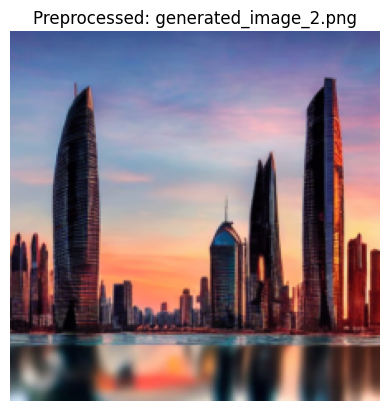

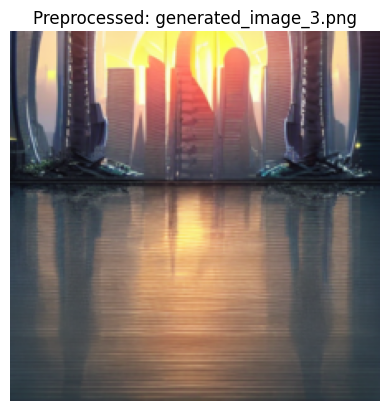

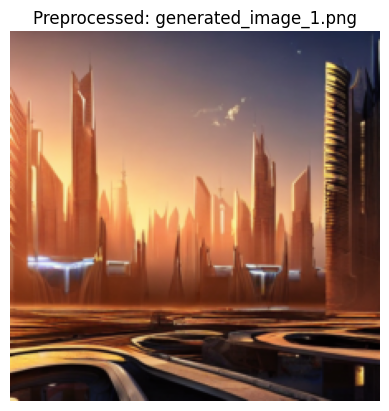

In [7]:
if __name__ == "__main__":
    # ============================================
    # Example: Generate Synthetic Images with Watermark
    # ============================================
    prompt_text = "a serene sunset over a futuristic city"
    generate_images(prompt=prompt_text,
                    num_images=3,
                    save_dir="./generated_images",
                    height=512,
                    width=512,
                    guidance_scale=7.5,
                    num_inference_steps=50,
                    seed=42,  # For reproducibility
                    output_format="png")

    # ============================================
    # Example: Preprocess the Generated Images
    # ============================================
    preprocess_images(input_dir="./generated_images",
                      output_dir="./preprocessed_images",
                      resize_to=(224, 224),
                      grayscale=False,
                      augment=True,    # Apply random horizontal flip augmentation
                      show_images=True)  # Set to True to display images after processing
